# Fundamentals of Social Data Science 
## Week 3 Day 2. Lab. Text Processing 

In this lab I have generated some methods that will allow you to download posts from Reddit. It accepts a list of subreddits of arbitrary length, which are each processed independently and stored in a single `results` dictionary. The keys of the dictionary are the subreddits. Underneath each subreddit is a dictionary of sub-specific result objects, like "vectorizer" and "top terms".

Please read through the code. You will need to add your username. The code is intentionally broken so you will need to add that before running this. Other than that you should not need to make any modifications to the cell with the `RedditScraper` class. 

In the cell below is some code to run these methods. At the top are some parameters that you should set. These are typically written in ALL CAPS. You should read the code to understand what they do. 

# Exercises: 
    
0. **Explore subreddits**. The below code uses 'ukpolitics', 'unitedkingdom', and 'uknews'. These were loosely motivated by an interest in whether uknews has become a reactionary subreddit with generally conservative opinions. By comparing it to the other two (which other work has suggested are generally quite similar), we might get a sense of this from the top keywords. Try some other subs related to a topic where you suspect there will be some interesting distinctions. Motivate the distinctions. If you aren't sure about the subs, query an LLM (they are typically trained on a _lot_ of Reddit data and will know good subs). So instead of trying for /r/men and /r/women, if you ask about subs for gender-based interests, it might suggest /r/TwoXChromosomes and /r/MensRights as interesting distinctions. 

    - Focused on 'usnews', 'democrat', 'republican'

1. **Understand the results data structure**. The `results` object returns the top 5 terms. How would you access more than 5 terms? Expand the results to see 10. Consider what way is more general and flexible. How might you change the code so that there is a `TOP_N = 10` which is then passed through the code so that the results dictionary contains ten terms in the "top_terms" DataFrame rather than hard coding it in the method below?

    - Edited the `analyze_subreddit` function

2. **Store results**. Every time we run the code we query Reddit again. How can we store our data so that it is cached for another round? There are many approaches to this and among your group you may discover everything from 'just save the json' to 'DataFrame and then export to feather' to some who would ambitiously use MongoDB. Given this is a simple exercise for now, keep this step simple as you need it to be while still usable enough if you want to add more data.

    - Stored results in a dictionary of dataframes (`dict_dataframes`)

3. **Plot keywords over time**. Expand your results to anywhere from 250 upwards (I would here cap at 500 max and think that the api might only return last 1000 but untested). Determine the top keywords using TFIDF. Then plot the frequency of these keywords over this time period for these results.   

4. **Table the most common URLs for stories**. Triangulate these plots with a table summarising the top news outlets for this sub in this time period. Notice the starter code to process this from the posts data that has been stored in a large `submissions` dictionary. Note, this code does not turn all the `json` into a DataFrame, but extracts only the URL column and processes that. It also uses a _regular expression_ to separate out the top level domain, which may or may not be the most robust.  

5. **Write a summary**. Solely for reflection at this point, write some intuitions that you discover with this exploration. 

## Caveats for the exercise: 
- Reddit might severely limit the number of posts you download using this scraper even with your name appropriately in the username, so be judicious with your exploration (hence exercise 2 _first_). 
- While you might not have extensive experience with Reddit, I can be confident that there are subreddits on most imaginable topics that can be found with little challenge. However, these subs will have vastly different numbers of subscribers and activity, so bear that in mind with any interpretation when tempted to generalise what is found _beyond_ Reddit (i.e. generalising from /r/republicans to Republicans in the US). 
- You may be tempted out of curiosity to expand your data collection. You will find that this will lead to a trade off if you do not further process your data. If you have 1000 rows for headlines and 3000 for words, that's a big matrix that has to be multiplied by vectors. At some point the size of the matrix will be unnecessary as well as slow. You may need to consider different parameters for `MIN_DOC_FREQ` to get a balance between a big matrix and a meaningful one. 
- These results have not been cleared for publication with CUREC, but only for use within classroom and for illustrative purposes. Please do not upload raw reddit data to your own GitHub archive nor seek to publish these results.  (Notice that I have pre-emtively edited the .gitignore to include a `data/` folder where you can store results without uploading them). Seek advice from research.fac@oii.ox.ac.uk for use for a comparable project should you wish to publish this work. If you wish to produce a blog post or other informal analysis, this should be presented in such a way that it is not misconstrued that the University has endorsed this work for publication. 

# Import pre-requisite packages

In [126]:
# Import pre-requisite packages
import requests
import time
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt


# Define the Reddit Scraper

In [16]:
class RedditScraper:
    def __init__(self, user_agent):
        """
        Initialize the scraper with a user agent string.
        Example user agent: "SDS_textanalysis/1.0 (by /u/your_username)"
        """
        self.headers = {'User-Agent': user_agent}
        self.base_url = "https://api.reddit.com"

       
        
    def get_subreddit_posts(self, subreddit, limit=100):
        """
        Collect posts from a subreddit with proper pagination and rate limiting.
        """
        posts = []
        after = None
        
        while len(posts) < limit:
            url = f"{self.base_url}/r/{subreddit}/new"
            params = {
                'limit': min(100, limit - len(posts)),
                'after': after
            }
            
            

            response = requests.get(url, headers=self.headers, params=params)
                # Verify=False: Avoid SSL certificate verification warning
            
            if response.status_code != 200:
                print(f"Error accessing r/{subreddit}: {response.status_code}")
                break
                
            data = response.json()
            new_posts = data['data']['children']
            if not new_posts:
                break
                
            posts.extend([post['data'] for post in new_posts])
            after = data['data']['after']
            
            if not after:
                break
                
            time.sleep(2) # Rate limiting for Reddit API
            
        return posts[:limit]



def preprocess_text(text):
    """
    Clean and normalize text.
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text



def analyze_vocabulary(texts, min_freq=2):
    """
    Analyze vocabulary distribution in a corpus.
    Returns word frequencies and vocabulary statistics.
    """
    # Tokenize all texts
    words = ' '.join(texts).split()
    
    # Count word frequencies
    word_freq = Counter(words)
    
    # Calculate vocabulary statistics
    total_words = len(words)
    unique_words = len(word_freq)
    
    # Create frequency distribution DataFrame
    freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
    freq_df['percentage'] = freq_df['frequency'] / total_words * 100
    freq_df = freq_df.sort_values('frequency', ascending=False)
    
    # Calculate cumulative coverage
    freq_df['cumulative_percentage'] = freq_df['percentage'].cumsum()
    
    stats = {
        'total_words': total_words,
        'unique_words': unique_words,
        'words_min_freq': sum(1 for freq in word_freq.values() if freq >= min_freq),
        'coverage_top_1000': freq_df.iloc[:1000]['frequency'].sum() / total_words * 100 if len(freq_df) >= 1000 else 100
    }
    
    return freq_df, stats



def analyze_subreddit(posts, max_terms=1000, min_doc_freq=2, TOP_N=5):
    """
    Analyze a single subreddit's posts independently.
    """
    # Combine title and selftext
    texts = [
        preprocess_text(post.get('title', '')) + ' ' + 
        preprocess_text(post.get('selftext', ''))
        for post in posts
    ]
    
    # Analyze vocabulary first
    freq_df, vocab_stats = analyze_vocabulary(texts, min_freq=min_doc_freq)
    
    # Initialize TF-IDF vectorizer for this subreddit
    stop_words = list(set(stopwords.words('english')))
    vectorizer = TfidfVectorizer(
        stop_words=stop_words,
        max_features=max_terms,
        min_df=min_doc_freq
    )
    
    # Compute TF-IDF
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get average TF-IDF scores
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top terms
    feature_names = vectorizer.get_feature_names_out()
    top_terms = pd.DataFrame({
        'term': feature_names,
        'score': mean_tfidf
    }).sort_values('score', ascending=False)
    
    return {
        'vocab_stats': vocab_stats,
        'freq_distribution': freq_df,
        'top_terms': top_terms.head(TOP_N),
        'vectorizer': vectorizer,
        'matrix_shape': tfidf_matrix.shape,
        'matrix_sparsity': 100 * (1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
    }




# Completing the exercises

## Task 0: Explore the data

In [32]:
# Example subreddits
subreddits = ['usnews', 'democrat', 'republican']

# Analysis parameters
MAX_TERMS = 1000
MIN_DOC_FREQ = 2
LIMIT = 300
USERNAME = "enthusiastic_meerkat" # Replace with your Reddit username
TOP_N = 10

# Initialize scraper
scraper = RedditScraper(
user_agent=f"SDS_textanalysis/1.0 (by /u/{USERNAME})"
)

# Analyze each subreddit independently
results = {}
submissions = {}

for subreddit in subreddits:
    print(f"\nAnalyzing r/{subreddit}...")

    # Collect posts
    submissions[subreddit] = scraper.get_subreddit_posts(subreddit, limit=LIMIT)

    # Analyze subreddit
    results[subreddit] = analyze_subreddit(
        submissions[subreddit],
        max_terms=MAX_TERMS,   # Maximum number of terms to keep
        min_doc_freq=MIN_DOC_FREQ,   # Term must appear in at least min_doc_freq documents
        TOP_N = TOP_N
    )

    # Print results for this subreddit
    print(f"\nVocabulary Statistics for r/{subreddit}:")
    print(f"Total words: {results[subreddit]['vocab_stats']['total_words']}")
    print(f"Unique words: {results[subreddit]['vocab_stats']['unique_words']}")
    print(f"Words appearing ≥{MIN_DOC_FREQ} times: {results[subreddit]['vocab_stats']['words_min_freq']}")
    print(f"Coverage by top {MAX_TERMS} words: {results[subreddit]['vocab_stats']['coverage_top_1000']:.2f}%")
    print(f"Matrix shape: {results[subreddit]['matrix_shape']}")
    print(f"Matrix sparsity: {results[subreddit]['matrix_sparsity']:.2f}%")

    print(f"\nTop {TOP_N} terms by TF-IDF score:")
    print(results[subreddit]['top_terms'][['term', 'score']].to_string())


Analyzing r/usnews...

Vocabulary Statistics for r/usnews:
Total words: 4369
Unique words: 1943
Words appearing ≥2 times: 588
Coverage by top 1000 words: 78.42%
Matrix shape: (300, 466)
Matrix sparsity: 98.80%

Top 10 terms by TF-IDF score:
         term     score
437        us  0.036226
250       man  0.030248
163   florida  0.027651
36   arrested  0.026551
328    police  0.025811
371      says  0.025491
455     woman  0.023775
111      dead  0.021147
167     found  0.020484
384  shooting  0.019100

Analyzing r/democrat...

Vocabulary Statistics for r/democrat:
Total words: 10632
Unique words: 2963
Words appearing ≥2 times: 1170
Coverage by top 1000 words: 79.94%
Matrix shape: (300, 861)
Matrix sparsity: 98.73%

Top 10 terms by TF-IDF score:
            term     score
779        trump  0.063916
339       harris  0.033674
459         maga  0.028191
780       trumps  0.028099
6           2025  0.023731
593      project  0.023405
235     election  0.020314
407       kamala  0.018229
638

In [33]:
# Data Exploration: 
submissions['republican'][0] # Example post from the democrat subreddit

url_list = [post['url'] for post in submissions['democrat']]
url_df = pd.DataFrame(url_list, columns=['url'])
url_df['domain'] = url_df['url'].str.extract(r'(https?://[^/]+)')

url_df['domain'].value_counts().head(10)

domain
https://www.reddit.com           42
https://i.redd.it                40
https://newrepublic.com          14
https://youtu.be                 13
https://www.independent.co.uk    10
https://www.rawstory.com          9
https://thehill.com               8
https://www.newsweek.com          8
https://www.nbcnews.com           8
https://www.thedailybeast.com     6
Name: count, dtype: int64

In [36]:
results['republican'].keys()

dict_keys(['vocab_stats', 'freq_distribution', 'top_terms', 'vectorizer', 'matrix_shape', 'matrix_sparsity'])

## Task 1: Change the limit of rows displayed

- See where we inserted `TOP_N` into the code

## Task 2: Storing the data

In [55]:
dict_dataframes = {}

for i in submissions: #Create a dictionary of dataframes
    title = f"df_{i}"
    dict_dataframes[title] = pd.DataFrame(submissions[i])
    print(f"Displaying {title}:")
    display(dict_dataframes[title].head(5))

# Alternatively if you want to create onl one specific dataframe — but this is not recommended as it is hard coding

# df_republicans = pd.DataFrame(submissions['republican'])

# display(df_republicans.head(5))

Displaying df_usnews:


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_patreon_flair,author_flair_text_color,permalink,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,None,USNEWS,,t2_3oo5t,False,None,0,False,"Ballot boxes set on fire in Vancouver, Portland",[],...,False,None,/r/USNEWS/comments/1gebudt/ballot_boxes_set_on...,False,https://www.kgw.com/article/news/politics/elec...,28195,1.730146e+09,0,None,False
1,None,USNEWS,,t2_1b7xi8jo3g,False,None,0,False,Jeff Bezos Denied He’d “Participate in Blackma...,[],...,False,None,/r/USNEWS/comments/1gdp5sr/jeff_bezos_denied_h...,False,https://2paragraphs.com/2024/10/jeff-bezos-den...,28195,1.730074e+09,0,None,False
2,None,USNEWS,,t2_sd4ec53h,False,None,0,False,Timothée Chalamet crashes his own look-alike c...,[],...,False,None,/r/USNEWS/comments/1gdjetu/timothée_chalamet_c...,False,https://apnews.com/article/timothee-chalamet-l...,28195,1.730058e+09,0,None,False
3,None,USNEWS,,t2_mln0gkh7v,False,None,0,False,US Navy will apologize for the 1882 obliterati...,[],...,False,None,/r/USNEWS/comments/1gcqrwc/us_navy_will_apolog...,False,https://apnews.com/article/navy-1882-tlingit-v...,28195,1.729965e+09,0,None,False
4,None,USNEWS,,t2_dt7kxtk8,False,None,0,False,"Sarah Danser, 'Naked and Afraid' star, dies af...",[],...,False,None,/r/USNEWS/comments/1gc1ulw/sarah_danser_naked_...,False,https://www.nbcnews.com/news/us-news/sarah-dan...,28195,1.729883e+09,0,None,False


Displaying df_democrat:


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,url_overridden_by_dest,media_metadata,is_gallery,gallery_data
0,None,Democrat,When former President Donald Trump met with th...,t2_8m31iyvl,False,None,0,False,MAGAs: Useful idiots or pitiful victims?,[],...,https://www.reddit.com/r/Democrat/comments/1gf...,3636,1.730317e+09,0,None,False,NaN,NaN,NaN,NaN
1,None,Democrat,I’m so LIVID! Just found out my husband just...,t2_5zqubvas,False,None,0,False,So LIVID,[],...,https://www.reddit.com/r/Democrat/comments/1gf...,3636,1.730307e+09,0,None,False,NaN,NaN,NaN,NaN
2,None,Democrat,,t2_1211nas30r,False,None,0,False,David DePape sentenced to life without parole ...,[],...,https://www.nbcnews.com/news/us-news/david-dep...,3636,1.730299e+09,0,None,False,https://www.nbcnews.com/news/us-news/david-dep...,NaN,NaN,NaN
3,None,Democrat,I have analyzed about 5 hours of debates/inter...,t2_6mf94yc2,False,None,0,False,Using layered voice analysis on candidates... ...,[],...,https://www.reddit.com/r/Democrat/comments/1gf...,3636,1.730229e+09,0,None,False,NaN,NaN,NaN,NaN
4,None,Democrat,,t2_1bt28zur73,False,None,0,False,Skooly Toonz: The Indictment Song!,[],...,https://youtu.be/0qSqLfoToik?si=jd1nHHMBkiiibXtH,3636,1.730227e+09,0,"{'type': 'youtube.com', 'oembed': {'provider_u...",False,https://youtu.be/0qSqLfoToik?si=jd1nHHMBkiiibXtH,NaN,NaN,NaN


Displaying df_republican:


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,is_gallery,title,...,permalink,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview
0,None,Republican,Just finished reading a quite shocking article...,t2_15l6rwldm2,False,None,0,False,True,Interesting story I read on the federalist.,...,/r/Republican/comments/1gfvfaj/interesting_sto...,False,https://www.reddit.com/gallery/1gfvfaj,201228,1.730318e+09,0,None,False,NaN,NaN
1,None,Republican,,t2_1kchh5je,False,None,0,False,NaN,Democrat NC State professor caught removing Tr...,...,/r/Republican/comments/1gfva1a/democrat_nc_sta...,False,https://www.thisweekinthetriangle.com/p/exclus...,201228,1.730317e+09,0,None,False,link,{'images': [{'source': {'url': 'https://extern...
2,None,Republican,,t2_2n5itl1r,False,None,0,False,NaN,Harris Campaign Caught Manipulating X To Censo...,...,/r/Republican/comments/1gfv6mn/harris_campaign...,False,https://thefederalist.com/2024/10/30/block-com...,201228,1.730317e+09,0,None,False,link,{'images': [{'source': {'url': 'https://extern...
3,None,Republican,Vote Trump. Vance 🇺🇲\n\nDon't forget to vote T...,t2_a2d99cgj,False,None,0,False,NaN,Kamala Came. She Saw. She Flopped at Rally of ...,...,/r/Republican/comments/1gfv5wd/kamala_came_she...,False,https://nypost.com/2024/10/30/opinion/kamala-h...,201228,1.730317e+09,0,None,False,link,{'images': [{'source': {'url': 'https://extern...
4,None,Republican,,t2_avxx6,False,None,0,False,NaN,"In Devastating Blow To Democrats, Supreme Cour...",...,/r/Republican/comments/1gfutz6/in_devastating_...,False,https://babylonbee.com/news/in-devastating-blo...,201228,1.730316e+09,0,None,False,link,{'images': [{'source': {'url': 'https://extern...


## Task 3: **Plot keywords over time**. 

Expand your results to anywhere from 250 upwards (I would here cap at 500 max and think that the api might only return last 1000 but untested). Determine the top keywords using TFIDF. Then plot the frequency of these keywords over this time period for these results

In [58]:
# Adjusted to loading 300 posts within each subreddit by editing LIMIT (under parameters of the function)

In [65]:
# Obtain the datetime of each post (row) within each subreddit

for title, df in dict_dataframes.items(): #For each dataframe in the dictionary of dataframe
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s') #Convert the created_utc column to datetime
    print(f"Displaying {title}")
    display(df.head(1)) #Notice that the 'created_utc' column is now in datetime format

Displaying df_usnews


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_patreon_flair,author_flair_text_color,permalink,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,None,USNEWS,,t2_3oo5t,False,None,0,False,"Ballot boxes set on fire in Vancouver, Portland",[],...,False,None,/r/USNEWS/comments/1gebudt/ballot_boxes_set_on...,False,https://www.kgw.com/article/news/politics/elec...,28195,2024-10-28 20:10:09,0,None,False


Displaying df_democrat


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,url_overridden_by_dest,media_metadata,is_gallery,gallery_data
0,None,Democrat,When former President Donald Trump met with th...,t2_8m31iyvl,False,None,0,False,MAGAs: Useful idiots or pitiful victims?,[],...,https://www.reddit.com/r/Democrat/comments/1gf...,3636,2024-10-30 19:35:49,0,None,False,NaN,NaN,NaN,NaN


Displaying df_republican


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,is_gallery,title,...,permalink,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview
0,None,Republican,Just finished reading a quite shocking article...,t2_15l6rwldm2,False,None,0,False,True,Interesting story I read on the federalist.,...,/r/Republican/comments/1gfvfaj/interesting_sto...,False,https://www.reddit.com/gallery/1gfvfaj,201228,2024-10-30 19:45:49,0,None,False,NaN,NaN


In [69]:
# Recall the top words for each subreddit

for title, df in results.items():
    print(f"\nTop {TOP_N} words for {title}:")
    display(df['top_terms']['term'])



Top 10 words for usnews:


437          us
250         man
163     florida
36     arrested
328      police
371        says
455       woman
111        dead
167       found
384    shooting
Name: term, dtype: object


Top 10 words for democrat:


779          trump
339         harris
459           maga
780         trumps
6             2025
593        project
235       election
407         kamala
638    republicans
222         donald
Name: term, dtype: object


Top 10 words for republican:


749       trump
782        vote
331      harris
390      kamala
224    election
771       vance
351    horrible
214        dont
592       rally
418        like
Name: term, dtype: object

In [74]:
import matplotlib.pyplot as plt

/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['created_utc'].dt.date
/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['created_utc'].dt.date
/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a

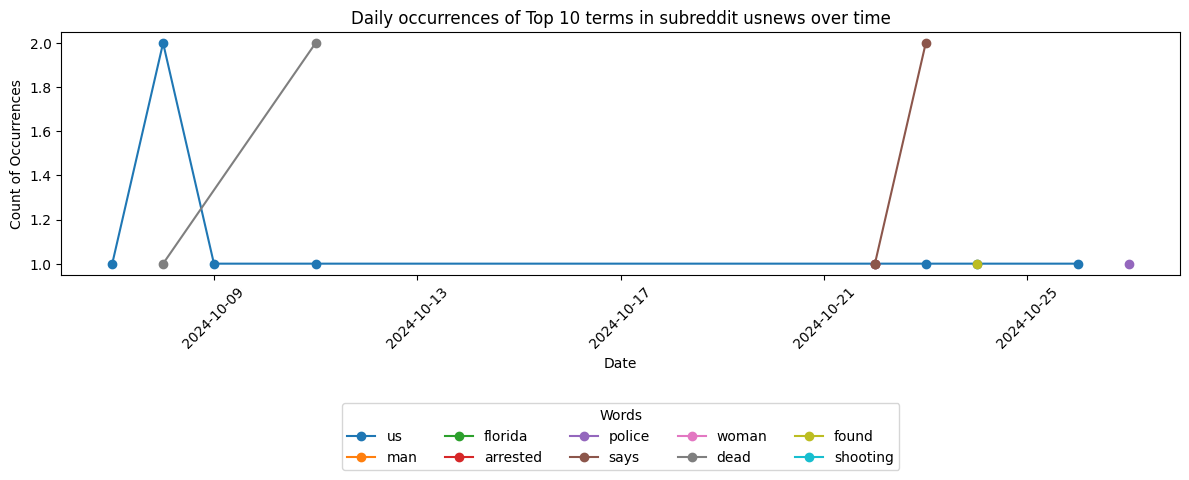

/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['created_utc'].dt.date
/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['created_utc'].dt.date
/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a

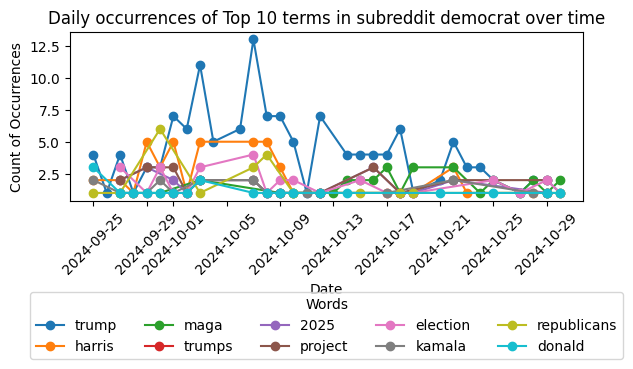

/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['created_utc'].dt.date
/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['created_utc'].dt.date
/var/folders/m4/4c1mlqzj06ndk225_4tybl880000gn/T/ipykernel_71546/3615684338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a

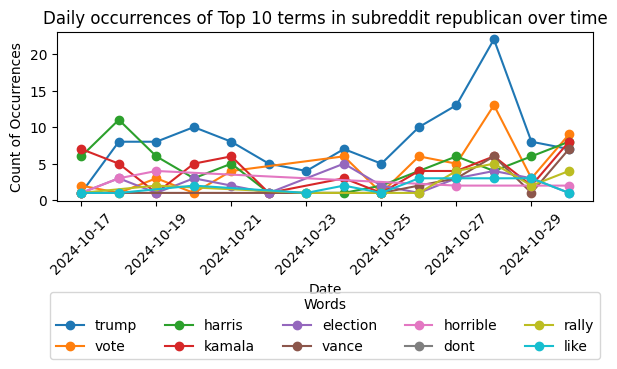

In [112]:
# Initialize plot
plt.figure(figsize=(12, 6))

cutoff_date = pd.Timestamp('2024-07-21') # This was when Biden formally withdrew from 2024 election


for subreddit_title, analysis in results.items():
    for word in analysis['top_terms']['term']:
        for df_title, df in dict_dataframes.items():
            # Ensure that the word only corresponds to the appropriate dataframe (ie resuts of X should be matched against df_X)
            if df_title == f"df_{subreddit_title}":
                # Filter the dataframe for the word
                filtered_df = df[
                    ((df['selftext'].str.lower().str.contains(word)) | (df['title'].str.lower().str.contains(word))) & \
                                (df['created_utc'] >= cutoff_date)
                ]
            
                
                # Group by date
                filtered_df['date'] = filtered_df['created_utc'].dt.date
                
                # Count number of posts containing the word per day
                word_counts = filtered_df.groupby('date').size()

                # Plot the word occurrences over time
                plt.plot(word_counts.index, word_counts.values, marker='o', label=f"{word}")


    plt.title(f"Daily occurrences of Top {TOP_N} terms in subreddit {subreddit_title} over time")
    plt.xlabel("Date")
    plt.ylabel("Count of Occurrences")
    plt.xticks(rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5, title="Words")
    plt.tight_layout()
    plt.show()


## Task 4: **Table the most common URLs for stories**. 

Triangulate these plots with a table summarising the top news outlets for this sub in this time period. 

- Notice the starter code to process this from the posts data that has been stored in a large `submissions` dictionary. 

- Note, this code does not turn all the `json` into a DataFrame, but extracts only the URL column and processes that. It also uses a _regular expression_ to separate out the top level domain, which may or may not be the most robust. 

In [125]:
# Create tables to show the top 10 words for each subreddit, after the cutoff date
#submissions['republican'][0] # Example post from the democrat subreddit

for title, df in dict_dataframes.items():
    url_list = df.loc[df['created_utc'] >= cutoff_date, 'url'].tolist()
    url_df = pd.DataFrame(url_list, columns=['url'])
    url_df['domain'] = url_df['url'].str.extract(r'(https?://[^/]+)')

    new_title = title.split('_')[1]

    print(f"\nTop 10 domains for subreddit '{new_title}' after cutoff date of {cutoff_date}:")
    print(url_df['domain'].value_counts().head(10))


Top 10 domains for subreddit 'usnews' after cutoff date of 2024-07-21 00:00:00:
domain
https://apnews.com          10
https://www.nbcnews.com      5
https://edition.cnn.com      2
https://www.kgw.com          1
https://2paragraphs.com      1
https://www.syriahr.com      1
https://www.foxnews.com      1
https://justthenews.com      1
https://www.usatoday.com     1
Name: count, dtype: int64

Top 10 domains for subreddit 'democrat' after cutoff date of 2024-07-21 00:00:00:
domain
https://www.reddit.com           42
https://i.redd.it                40
https://newrepublic.com          14
https://youtu.be                 13
https://www.independent.co.uk    10
https://www.rawstory.com          9
https://thehill.com               8
https://www.newsweek.com          8
https://www.nbcnews.com           8
https://www.thedailybeast.com     6
Name: count, dtype: int64

Top 10 domains for subreddit 'republican' after cutoff date of 2024-07-21 00:00:00:
domain
https://i.redd.it            36
https:/

## Task 5: **Write a summary**. 

Solely for reflection at this point, write some intuitions that you discover with this exploration. 

**Response**

1. I decided to compare between 'usnews', 'democrat', and 'republican', given that this notebook was attempted on 30 Oct 2024, less than a week before the US 2024 election

    a. For context, the president - vicepresident candidate pairs are as follows:

    &nbsp;&nbsp;&nbsp;&nbsp; i. Democrat: Kamala Harris - Tim Walz
         
    &nbsp;&nbsp;&nbsp;&nbsp; ii. Republican: Donald Trump - JD Vance


**[Noteworthy obervations]**

2. The top 10 most important keywords under the 'usnews' corpus appear to have little relation to the 2024 election.

    a. This is expected, given that the usnews also covers issues beyond the election


3. The name of the Republican candidate, 'Trump' appears as the top 1 most important keyword under both the 'democrat' and 'republican' corpus

    a. This is suprising, as we would expect the 'democrat' corpus to place more emphasis on their candidate 'Harris'


4. 5 out of 10 of the most important keywords under the 'democrat' corpus are related to the Republican campaign. In contrast, 2 out of 10 of the most important keywords under the 'republican' corpus are related to the Democrat campaign. 

    a. This is surprising. It seems to point towards the democrat campaign being more intentional in establishing a comparison between themselves and the republican campaign, whereas the republican campaign seems to be focused more on its own reputation

5. Within the top 10 most important keywords under each corpus, while the Republican vice presidential candidate 'vance' appears in the 'republican' corpus, the Demorat vice presidential candidate does not appear in the 'demorat' corpus

    a. It seems to point that the Republican vice presidential candidate has more public attention compared to the Demorat vice presidential candidate

6. Within the 10 most used domains, the 'republican' corpus appears to feature more conservative (and even far-right) media such as breitbart.com and nypost.com, whereas the 'democrat' corpus appears to feature more liberal media such as newrepublic.com and nbcnews.com. Additionally, X appears to be featured more prominently in the 'republican' corpus, rather than the 'democrat' corpus

    a. This is not very surprising. This is supported by research that found that individuals tend to seek media which reinforces their opinions rather than challenges their opinions, highlighting the entrenchment of an echo chamber.

    b. Furthermore, the prominence of X (formerly twitter) could have been due to several reasons such as Elon Musk's (CEO of X) support for Trump, and Trump's infamous use of X


# Where we are headed with this exercise 

### Today: 
Collect reddit data, make it robust and explore TF-IDF results. 

### Week 3 Day 3. Friday: 
We use contine the use of the TF-IDF matrix and introduce cosine distance. We show how to plot it using t-SNE. This might sound abstract but the results will be fascinating as we see words plotted in coherent clusters that seem to reveal inductive patterns. 

Worksheets will be uploaded to this repo. 

### Week 4 Day 1. Monday: 
We will use two simple forms of classification, k-means and Naive Bayes Clustering. You might also be familiar with LDA or 'topic modelling'. We will not cover this as the technique deserves some care to understand its internals even if it is easy to run out of the box. But it is not far as an extension from where we end up. 

In the lab we will then compare classification results to results from the t-SNE and exploration of distance from Friday. 

### Week 4 Day 2. Wednesday: 
We will introduce the `networkx` and `community` package and show how to both construct a network from threaded comments and users of these comments. This will involve two types of graphs: DAGs and Bipartite graphs. 

In the lab you will have code that shows how to do this with the Reddit data in general. You will have to apply this to your specific case. 

### Week 4 Day 3. Friday: 
In the walkthrough we will see how to create 'embeddings' as abstractions even further than t-SNE but as a next-step up from cosine distance. In fact we will see how you can use cosine distance on embeddings which allows you to do these same steps not with words, but with entire sentences or whole paragraphs. We feature this on Friday and assume that your presentations will not need to use embeddings. 

In the afternoon you we will have the second set of group presentations: 
- Take a current event or coherent topic that could be collected from reddit data using the requests API (or more abstract packages such as `praw`, but not entire archive dumps like PushShift, only a limited subset). 
- Look at three or more subreddits who might speak to that topic. Determine which two subs are the most similar and why? Be sure to consider not only common word use. You may define similarity in creative ways so long as they can result in calculable differences without use of ML models, external APIs, or mass labelling of data. If you can download a lexicon, you are welcome to use scoring.
- Motivate this topic deductively. Where possible try to draw upon any existing literature on the topic and not simply abductively from current events. Consider DIKW: Find ways to produce transferable _knowledge_ rather than merely _information_ from _data_. 

# AI Declaration: 

Claude Sonnet 3.5 New produced much of the reddit code. I was surprised at how similar it was to my past code (knowing it was trained on GitHub I have to wonder). Several tweaks had to be made such as removing a main() function, altering the results object, altering some NLTK packages, adding the submissions dictionary and the submissions dictionary code. I kept in the `preprocess_text()` function as is, but you are encouraged to consider alternative forms of pre-processing from the walkthrough including the use of standard tokenizers, lemmatisation, and stop-words. It also used anodyne programming subreddits which I changed and I reduced the limit to 50 which is just enough to get two queries illustrating that you can get N queries through this approach. 

The URL code was written in VS code with co-pilot. Notably the autocomplete did an excellent job of anticipating steps with minimal prompting. 